In [1]:
# pwd is /content
cd /content/drive/My Drive/deep-learning-v2-pytorch/convolutional-neural-networks/cifar-cnn

/content/drive/My Drive/deep-learning-v2-pytorch/convolutional-neural-networks/cifar-cnn


In [4]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [6]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 50
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
ntransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=ntransform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [31]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.Conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.Conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.Conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        self.Conv4 = nn.Conv2d(64, 128, 3, padding = 1)
        
        
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x =  self.bn1( F.relu( self.Conv1(x) ) )
        x =  self.pool( self.bn2( F.relu( self.Conv2(x) ) ) ) 
        x =  F.dropout( self.pool(self.bn3( F.relu( self.Conv3(x) ) )), p = 0.2)
        x =  F.dropout( self.pool( self.bn4( F.relu( self.Conv4(x) ) )) , p =0.2 )
        x = x.view(-1, 128 * 4 * 4)
        x = F.dropout( F.relu(self.fc1(x)), p = 0.3)
        x = F.dropout( F.relu(self.fc2(x)), p = 0.3)
        x = self.fc3(x)
        
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (Conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [32]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.3)

# number of epochs to train the model
n_epochs = 100 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

train_lossA, valid_lossA = [], []
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()
    
    # calculate average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)
    train_lossA.append(train_loss)
    valid_lossA.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.562138 	Validation Loss: 1.271077
Validation loss decreased (inf --> 1.271077).  Saving model ...
Epoch: 2 	Training Loss: 1.149354 	Validation Loss: 1.065375
Validation loss decreased (1.271077 --> 1.065375).  Saving model ...
Epoch: 3 	Training Loss: 0.981315 	Validation Loss: 0.942954
Validation loss decreased (1.065375 --> 0.942954).  Saving model ...
Epoch: 4 	Training Loss: 0.882145 	Validation Loss: 0.911989
Validation loss decreased (0.942954 --> 0.911989).  Saving model ...
Epoch: 5 	Training Loss: 0.815528 	Validation Loss: 0.824106
Validation loss decreased (0.911989 --> 0.824106).  Saving model ...
Epoch: 6 	Training Loss: 0.758329 	Validation Loss: 0.795524
Validation loss decreased (0.824106 --> 0.795524).  Saving model ...
Epoch: 7 	Training Loss: 0.716618 	Validation Loss: 0.753402
Validation loss decreased (0.795524 --> 0.753402).  Saving model ...
Epoch: 8 	Training Loss: 0.678221 	Validation Loss: 0.739285
Validation loss decreased (0.75340

KeyboardInterrupt: ignored

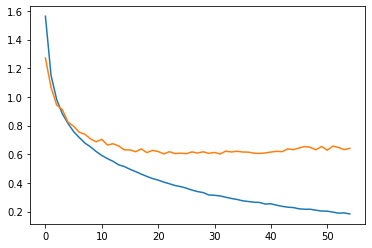

In [34]:
import matplotlib.pyplot as plt
plt.plot(train_lossA)
plt.plot(valid_lossA)
plt.show()


In [36]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [37]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
with torch.no_grad():
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.604421

Test Accuracy of airplane: 85% (856/1000)
Test Accuracy of automobile: 91% (915/1000)
Test Accuracy of  bird: 69% (696/1000)
Test Accuracy of   cat: 61% (613/1000)
Test Accuracy of  deer: 79% (794/1000)
Test Accuracy of   dog: 75% (756/1000)
Test Accuracy of  frog: 87% (878/1000)
Test Accuracy of horse: 85% (855/1000)
Test Accuracy of  ship: 88% (889/1000)
Test Accuracy of truck: 86% (868/1000)

Test Accuracy (Overall): 81% (8120/10000)
